In [ ]:
from CO2_Dataset_Preparation import *
from ML_Model_Master import *
from Result_Retriever import *
from datetime import datetime
import pickle

In [ ]:
# position_number = 4
feature_columns = ['Pic_CO2','ANEM_X','ANEM_Y','ANEM_Z','wd','ws']
downsample_sec = 600
periods_to_lag = 3
tower = 'Picarro'
train_percent = 0.7

#Model Parameters
activation = 'relu'
neurons = [128]
dropout_rate = [0.2,0.3]
learn_rate = [0.001]#,1e-4,1e-5]
decay = [1e-5]#,1e-6]
batch_size = [10,20]#,50,100]
epochs = [5,10]#,50,100]
error_metric = 'rmse'

#file_name = 'testlog'#'ML_Models/PN{}_DS{}_Lag{}_Neur{}_DR{}'.format(position_number,downsample_sec,periods_to_lag[0],neurons[0],dropout_rate[0])
#logfile=open('{}.txt'.format(file_name),'w')

logfile = None

In [ ]:
#Preprocess data and save as pkl

# data = Dataset('../CO2_Data_Final',position_number,logfile = logfile)
# data._preprocess()

# ml_data = ML_Data(feature_columns,downsample_sec,periods_to_lag[0],tower,train_percent)
# ml_data._ML_Process(data)

# with open('ML_dataset_{}DS.pkl'.format(downsample_sec), 'wb') as file:
#     pickle.dump(ml_data, file)

In [ ]:
#Load Preprocessed Dataset
with open('ML_dataset_{}DS.pkl'.format(downsample_sec), 'rb') as file:
    ml_data = pickle.load(file)

In [ ]:
try:
    print_log_flush("-------------------------BUILD AND TRAIN MODELS-------------------------",logfile)

    tot_train = len(neurons)*len(dropout_rate)*len(learn_rate)*len(decay)*len(batch_size)*len(epochs)-1

    models = []
    i = 0


    for neur in neurons:
        for dr in dropout_rate:
            for lr in learn_rate:
                for dec in decay:
                    for bs in batch_size:
                        for ep in epochs:
                            print_log_flush(f"---Training Model: {i} of {tot_train}---",logfile)
                            ml_model = ML_Model_Builder(activation,neur,dr,lr,dec,bs,ep)
                            ml_model._train_model(ml_data)
                            delattr(ml_model,'logfile')
                            models.append(ml_model)
                            print(models)
                            i+=1

    error_name  = 'rmse'   

    error_vals = []
    for m in models:
        error_vals.append(m.history.history[error_name][-1])
    best_idx = error_vals.index(min(error_vals))

    print_log_flush("-------------------------RESULTS-------------------------",logfile)

    print_log_flush(f"Best score for '{error_name}' was {min(error_vals)} in model {best_idx}",logfile)

    print_log_flush(f"Downsampling Seconds: {models[best_idx].downsample_sec}\n\
    Lag Periods: {models[best_idx].periods_to_lag}\n\
    Activation: {models[best_idx].activation}\n\
    Neurons: {models[best_idx].neurons}\n\
    Learning Rate: {models[best_idx].learn_rate}\n\
    Decay: {models[best_idx].decay}\n\
    Epochs: {models[best_idx].epochs}",logfile)

    print_log_flush("-------------------------SAVE FILE-------------------------",logfile)

    with open('{}.pkl'.format(file_name), 'wb') as models_file:
         pickle.dump(models, models_file)

    print_log_flush(f"Saved list of models to {file_name}",logfile)
    print_log_flush(f"Models built with optimizer: {models[best_idx].opt_string}",logfile)

    now = datetime.now()
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
    print_log_flush('*******************************END TIME = {}************************************'.format(dt_string),logfile)
except Exception as e:
    print_log_flush('Error occurred ' + str(e),logfile)
if logfile is not None:
    logfile.close()

In [ ]:
import matplotlib.pyplot as plt

i=best_idx

models[i]._fit_data(ml_data)

#Return to original data shape and scale
X_test_original_shape = ml_data.X_test.reshape(ml_data.orig_X_test_shape) #reshape from 3d time
y_test_original_shape = ml_data.y_test.reshape(ml_data.orig_y_test_shape)#reshape from 3d time 

merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = ml_data.y_fit.reshape(ml_data.orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))
# ax.plot(ml_data.y_fit,label='ML_Fit_to_Test')
# ax.plot(ml_data.y_test,label='Actual_Test_Data')

roll = 1

ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Predicted')
ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')

ax.set_xlabel('Time (s)',fontsize=16)
ax.set_ylabel('Mass Flow from Vent (g/s)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


ax.legend(fontsize=16)
plt.show()

-----Generating Data Variables-----
-----Reading Model Outputs-----
-----Finding Best Model-----
Best Model Index = 0
-----Setup Data for Best Model Retrain-----
Retrieving data for 2019-09-24
Retrieving data for 2019-09-25
Retrieving data for 2019-09-26
Retrieving data for 2019-09-27
Retrieving data for 2019-09-28
Retrieving data for 2019-09-29
Retrieving data for 2019-09-30
Retrieving data for 2019-10-01
Retrieving data for 2019-10-02
Retrieving data for 2019-10-03
Removing Impulses
Downsampling and Concatenating
Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero
Downsampling by mean at 600 seconds
Downsampling by mean at 600 seconds
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'
-----Regenerating Best Model-----
-----Retraining Best Model-----
Downsampling = 600
Lag Periods = 2        
activation=relu
neurons=128
dropout_rate=0.2        
learn_rate=0.001
decay=1e-05
batch size=10
epochs=5
Train on 904 samples, validate on 388 samples
Epoch 1

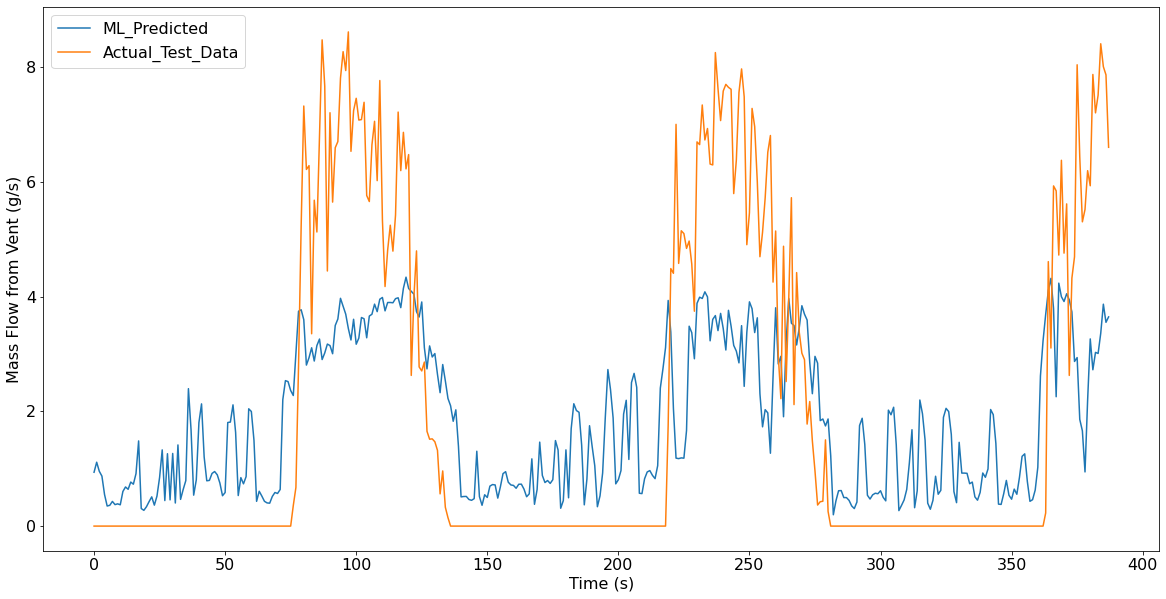

In [2]:
from Result_Retriever import *

logfile = f'Gridsearch_Output/Picarro_PN4_DS600_Lag2_Train0.7.out'
g = Gridsearch_Result_Retrieve(logfile)
g._read_data_vars()
g._read_models()
g._find_best_model()
g._get_best_data('../CO2_Data_Final')
g._retrain_fit_best()
g._plot_best_comparison(1)